In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n = 4 # n qubits
m = 2 * n # double qubits for preparing target state
n_layers = n ** 2 # number of layers in variational circuit
if n == 1:
    n_layers = 0
dev = qml.device('default.qubit', wires=m)

In [3]:
def variational_circuit(n_layers, weights, wires, **kwargs):
    '''
        Template for a variational circuit.
    '''
    pos = 0
    for i in range(len(wires)):
        qml.RX(weights[pos], wires=wires[i])
        qml.RY(weights[pos+1], wires=wires[i])
        qml.RZ(weights[pos+2], wires=wires[i])
        pos += 3

    for layer in range(n_layers):
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        
        for i in range(len(wires)):
            qml.RX(weights[pos], wires=wires[i])
            qml.RY(weights[pos+1], wires=wires[i])
            qml.RZ(weights[pos+2], wires=wires[i])
            pos += 3

In [4]:
def get_target(n_layers, params, **kwargs):
    '''
        Prepare target state at the first n qubits.
    '''
    variational_circuit(n_layers, params, np.arange(m))

In [5]:
def variational_qpca(n_layers, variational_params, **kwargs):
    '''
        Perform variational quantum PCA.
    '''
    variational_circuit(n_layers, variational_params, np.arange(n))

In [6]:
@qml.qnode(dev, interface="tf")
def measurement(n_layers, target_params, variational_params, **kwargs):
    '''
        Measure sigma_z for computing PCA loss.
    '''
    get_target(n_layers, target_params)
    variational_qpca(n_layers, variational_params)
    z = []
    for i in range(n):
        z.append(qml.expval(qml.PauliZ(i)))
    return z

def loss_qpca(n_layers, target_params, variational_params, **kwargs):
    '''
        Compute loss for variational quantum PCA, i.e. $Tr(U \rho U^dagger P)$.
    '''
    z = measurement(n_layers, target_params, variational_params)
    return 1 / 2 ** n / (2 ** n - 1) * tf.math.reduce_sum((z + 1) * (2 ** tf.range(n, dtype=tf.double)))

In [28]:
# initialize parameters
np.random.seed(0)
tf.random.set_seed(0)
n_target_params = (n_layers + 1) * 3 * m
n_var_params = (n_layers + 1) * 3 * n

target_params = np.array([0] * n_target_params) + np.random.normal(scale=np.pi, size=(n_target_params,))

eps = 1e-2
init_var_params = np.array([0] * n_var_params) + np.random.normal(scale=eps, size=(n_var_params,))
var_params = tf.Variable(init_var_params)

# SGD faces barren plateau, Adam is better
# lr = 6 for SGD, 0.1 for Adam
# opt = tf.keras.optimizers.SGD(6)
opt = tf.keras.optimizers.Adam(0.1)

In [29]:
# examine the target state
@qml.qnode(dev, interface="tf")
def get_target_state(n_layers, target_params, **kwargs):
    '''
        Get density matrix of the target state.
    '''
    get_target(n_layers, target_params)
    return qml.density_matrix(list(range(n)))

# sigular value decomposition
target_state = get_target_state(n_layers, target_params).numpy()
U, S, V = np.linalg.svd(target_state)
print('eigenvalues: ', S)

# calculate theoretical minimum of loss
loss_minimum = np.sum(S * np.arange(len(S))) / 2 ** n / (2 ** n - 1) * 2
print('loss minimum: ', loss_minimum)

eigenvalues:  [2.17700316e-01 1.81401684e-01 1.38392838e-01 1.19328333e-01
 8.64941820e-02 6.76431777e-02 4.87401697e-02 4.05142797e-02
 2.96022492e-02 2.53171071e-02 1.91009725e-02 1.15756290e-02
 8.28834778e-03 4.12904668e-03 1.68351381e-03 8.81536456e-05]
loss minimum:  0.025312073598619776


In [33]:
# train variational quantum PCA
n_step = 200

cost = lambda: loss_qpca(n_layers, target_params, var_params)

# cost_list = []
for step in range(n_step):
    opt.minimize(cost, var_params)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        print("Step {}: cost = {}, relative excess = {}".format(step, cost_val, (cost_val - loss_minimum) / loss_minimum))

Step 0: cost = 0.025518067701214182, relative excess = 0.008138175712543706
Step 5: cost = 0.02556084917843894, relative excess = 0.00982833661769733
Step 10: cost = 0.025517732810588778, relative excess = 0.008124945242740446
Step 15: cost = 0.025494926000399303, relative excess = 0.007223920279273274
Step 20: cost = 0.02549727390998366, relative excess = 0.007316678763686164
Step 25: cost = 0.025498208619675878, relative excess = 0.007353606188402178
Step 30: cost = 0.02549525691231594, relative excess = 0.00723699356287236
Step 35: cost = 0.025491810899106234, relative excess = 0.007100852476039681
Step 40: cost = 0.02548907131045504, relative excess = 0.006992619990047513
Step 45: cost = 0.025486878103961705, relative excess = 0.0069059733356440795
Step 50: cost = 0.025484888097538964, relative excess = 0.0068273544735825515
Step 55: cost = 0.025483002889224546, relative excess = 0.006752875853446085
Step 60: cost = 0.0254814267240836, relative excess = 0.006690606552007594
Step 65

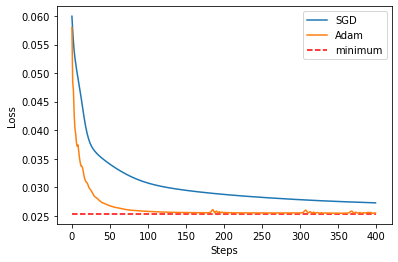

In [34]:
# plot loss
plt.plot(cost_list_sgd[:400], label='SGD')
plt.plot(cost_list, label='Adam')
plt.hlines(loss_minimum, 0, n_step*2, colors='r', linestyles='--', label='minimum')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
@qml.qnode(dev, interface="tf")
def get_pca_state(n_layers, target_params, variational_params, **kwargs):
    '''
        Get density matrix of the PCA result.
    '''
    get_target(n_layers, target_params)
    variational_qpca(n_layers, variational_params)
    return qml.density_matrix(list(range(n)))

eigenvalues:  [2.17700316e-01 1.81401684e-01 1.38392838e-01 1.19328333e-01
 8.64941820e-02 6.76431777e-02 4.87401697e-02 4.05142797e-02
 2.96022492e-02 2.53171071e-02 1.91009725e-02 1.15756290e-02
 8.28834778e-03 4.12904668e-03 1.68351381e-03 8.81536456e-05]
pca results:  [0.21696791 0.18143984 0.13851553 0.11895324 0.08650029 0.06748182
 0.04799025 0.04145043 0.02931042 0.02464652 0.01943413 0.01176594
 0.00738517 0.00485605 0.00190713 0.00139532]
eigenvalue mse:  3.7146584986516094e-07


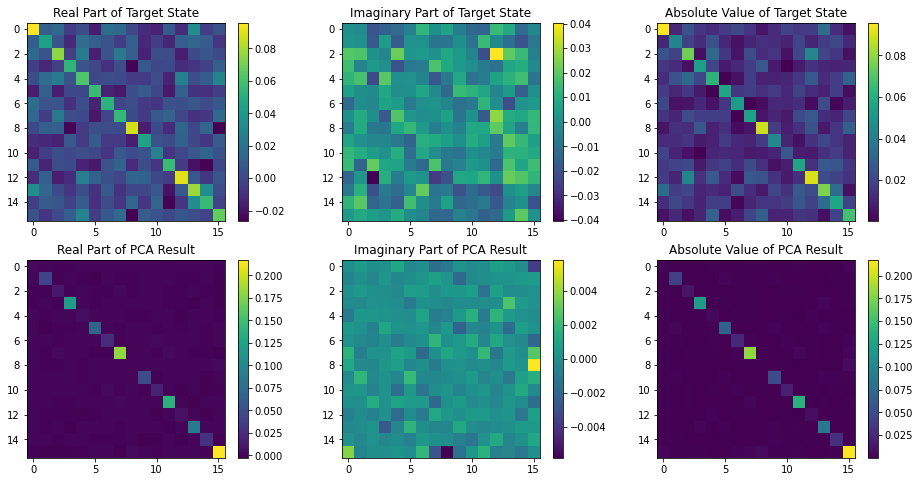

In [36]:
print('eigenvalues: ', S)

# extract and compute eigenvalues from qpca
pca_state = get_pca_state(n_layers, target_params, var_params).numpy()
pca_eigen, order = np.unique(-np.abs(np.diag(pca_state)), return_inverse=True)
pca_eigen = -pca_eigen

print('pca results: ', pca_eigen)
print('eigenvalue mse: ', np.mean((pca_eigen - S) ** 2))

# plot target and pca state
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

im_target_real = ax[0][0].imshow(np.real(target_state))
ax[0][0].set_title('Real Part of Target State')
plt.colorbar(im_target_real, ax=ax[0][0])
im_target_imag = ax[0][1].imshow(np.imag(target_state))
ax[0][1].set_title('Imaginary Part of Target State')
plt.colorbar(im_target_imag, ax=ax[0][1])
im_target_abs = ax[0][2].imshow(np.abs(target_state))
ax[0][2].set_title('Absolute Value of Target State')
plt.colorbar(im_target_abs, ax=ax[0][2])

im_pca_real = ax[1][0].imshow(np.real(pca_state))
ax[1][0].set_title('Real Part of PCA Result')
plt.colorbar(im_pca_real, ax=ax[1][0])
im_pca_imag = ax[1][1].imshow(np.imag(pca_state))
ax[1][1].set_title('Imaginary Part of PCA Result')
plt.colorbar(im_pca_imag, ax=ax[1][1])
im_pca_abs = ax[1][2].imshow(np.abs(pca_state))
ax[1][2].set_title('Absolute Value of PCA Result')
plt.colorbar(im_pca_abs, ax=ax[1][2])

plt.show()

In [37]:
dev_gen = qml.device('default.mixed', wires=n)
@qml.qnode(dev_gen, interface=None)
def generator(pca_eigs, n_layers, variational_params):
    '''
        Generate state via qPCA^dagger.
    '''
    qml.QubitDensityMatrix(np.diag(pca_eigs), wires=list(range(n)))
    qml.adjoint(variational_qpca)(n_layers, variational_params)
    return qml.density_matrix(list(range(n)))

mse of generated state:  1.602942896488519e-05


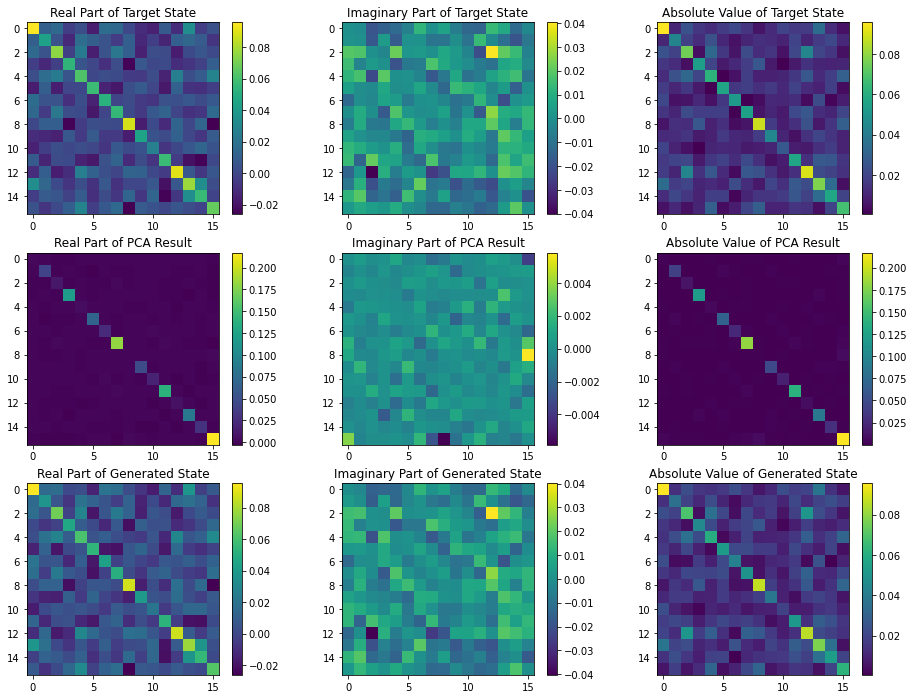

In [50]:
# truncate eigenvalues
n_trunc = 8
trunc_pca_eigs = np.pad(pca_eigen[:n_trunc]/np.sum(pca_eigen[:n_trunc]), (0, n ** 2 - n_trunc), 'constant')[order]
gen_state = generator(trunc_pca_eigs, n_layers, var_params)

# print('real eigs sorted:\n', S)
# print('pca eigs sorted:\n', pca_eigen)
# print('pca eigs:\n', np.diag(pca_state))
# print('trunc pca eigs:\n', trunc_pca_eigs)

print('mse of generated state: ', np.mean(np.abs(gen_state - target_state)**2))

fig, ax = plt.subplots(3, 3, figsize=(16, 12))

im_target_real = ax[0][0].imshow(np.real(target_state))
ax[0][0].set_title('Real Part of Target State')
plt.colorbar(im_target_real, ax=ax[0][0])
im_target_imag = ax[0][1].imshow(np.imag(target_state))
ax[0][1].set_title('Imaginary Part of Target State')
plt.colorbar(im_target_imag, ax=ax[0][1])
im_target_abs = ax[0][2].imshow(np.abs(target_state))
ax[0][2].set_title('Absolute Value of Target State')
plt.colorbar(im_target_abs, ax=ax[0][2])

im_pca_real = ax[1][0].imshow(np.real(pca_state))
ax[1][0].set_title('Real Part of PCA Result')
plt.colorbar(im_pca_real, ax=ax[1][0])
im_pca_imag = ax[1][1].imshow(np.imag(pca_state))
ax[1][1].set_title('Imaginary Part of PCA Result')
plt.colorbar(im_pca_imag, ax=ax[1][1])
im_pca_abs = ax[1][2].imshow(np.abs(pca_state))
ax[1][2].set_title('Absolute Value of PCA Result')
plt.colorbar(im_pca_abs, ax=ax[1][2])

im_gen_real = ax[2][0].imshow(np.real(gen_state))
ax[2][0].set_title('Real Part of Generated State')
plt.colorbar(im_target_real, ax=ax[2][0])
im_gen_imag = ax[2][1].imshow(np.imag(gen_state))
ax[2][1].set_title('Imaginary Part of Generated State')
plt.colorbar(im_target_imag, ax=ax[2][1])
im_gen_abs = ax[2][2].imshow(np.abs(gen_state))
ax[2][2].set_title('Absolute Value of Generated State')
plt.colorbar(im_target_abs, ax=ax[2][2])

plt.show()

In [53]:
# relative entropy
from scipy.linalg import logm
def relative_entropy(rho, sigma):
    return -np.real(np.trace(np.dot(rho, logm(sigma)-logm(rho))))
print('relative entropy: ', relative_entropy(gen_state, target_state))

relative entropy:  0.1092299322048762
